</b>Comparative Study of Green's Functions from Ambient Noise Cross-Correlation Before and After a Small Earthquake</b>

</strong>To investigate changes in the Earth's structure caused by an earthquake, one can compare the Green's functions derived from ambient noise cross-correlation before and after the event. The Green's function represents the impulse response of the medium between two receivers and contains information about the Earth's subsurface structure. By analyzing the power spectra and applying different frequency filters to the pre- and post-earthquake Green's functions, we can identify any significant changes.We used data from the 2.3 magnitude earthquake that occurred on August 30, 2022, at 21:14:53 UTC. The earthquake's epicenter was located at latitude 40.9223° N and longitude -74.5313° W, with a depth of 5.0 kilometers in Morris County, New Jersey.
For our analysis, we utilized continuous noise data from two seismic stations:
Station Code: GEDE
Latitude: 39.81° N
Longitude: -75.64° W
Elevation: 105 m
Data Center: IRISDMC
Station Code: KSCT
Latitude: 41.73° N
Longitude: -73.48° W
Elevation: 114 m
Data Center: IRISDMC</strong>

</strong>Displaying the position of stations and events using GMT


 # Step 1: Create a base map with coastlines
gmt pscoast -JM6 -R-78/-70/38/42 -Dl -G200 -B1/1 -K >! map.ps

 # Step 2: Plot the earthquake event as a star
gmt psxy event.txt -JM6 -R-78/-70/38/42 -Sa0.3i -Gred -O -K >> map.ps

 # Step 3: Plot the stations as triangles
gmt psxy station.txt -JM6 -R-78/-70/38/42 -St0.3i -Gblue -O -K >> map.ps

echo "-74.00 40.92 Earthquake" | gmt pstext -JM6 -R-78/-70/38/42 -F+f12p,Helvetica-Bold,red+jTL -O -K >> map.ps

 # Step 5: Add labels for the stations
echo "-73.00 41.73 KSCT" | gmt pstext -JM6 -R-78/-70/38/42 -F+f12p,Helvetica-Bold,blue+jTL -O -K >> map.ps
echo "-75.2 39.81 GEDE" | gmt pstext -JM6 -R-78/-70/38/42 -F+f12p,Helvetica-Bold,blue+jTL -O >> map.ps

gv map.ps
gmt psconvert map.ps -A -Tg</strong>

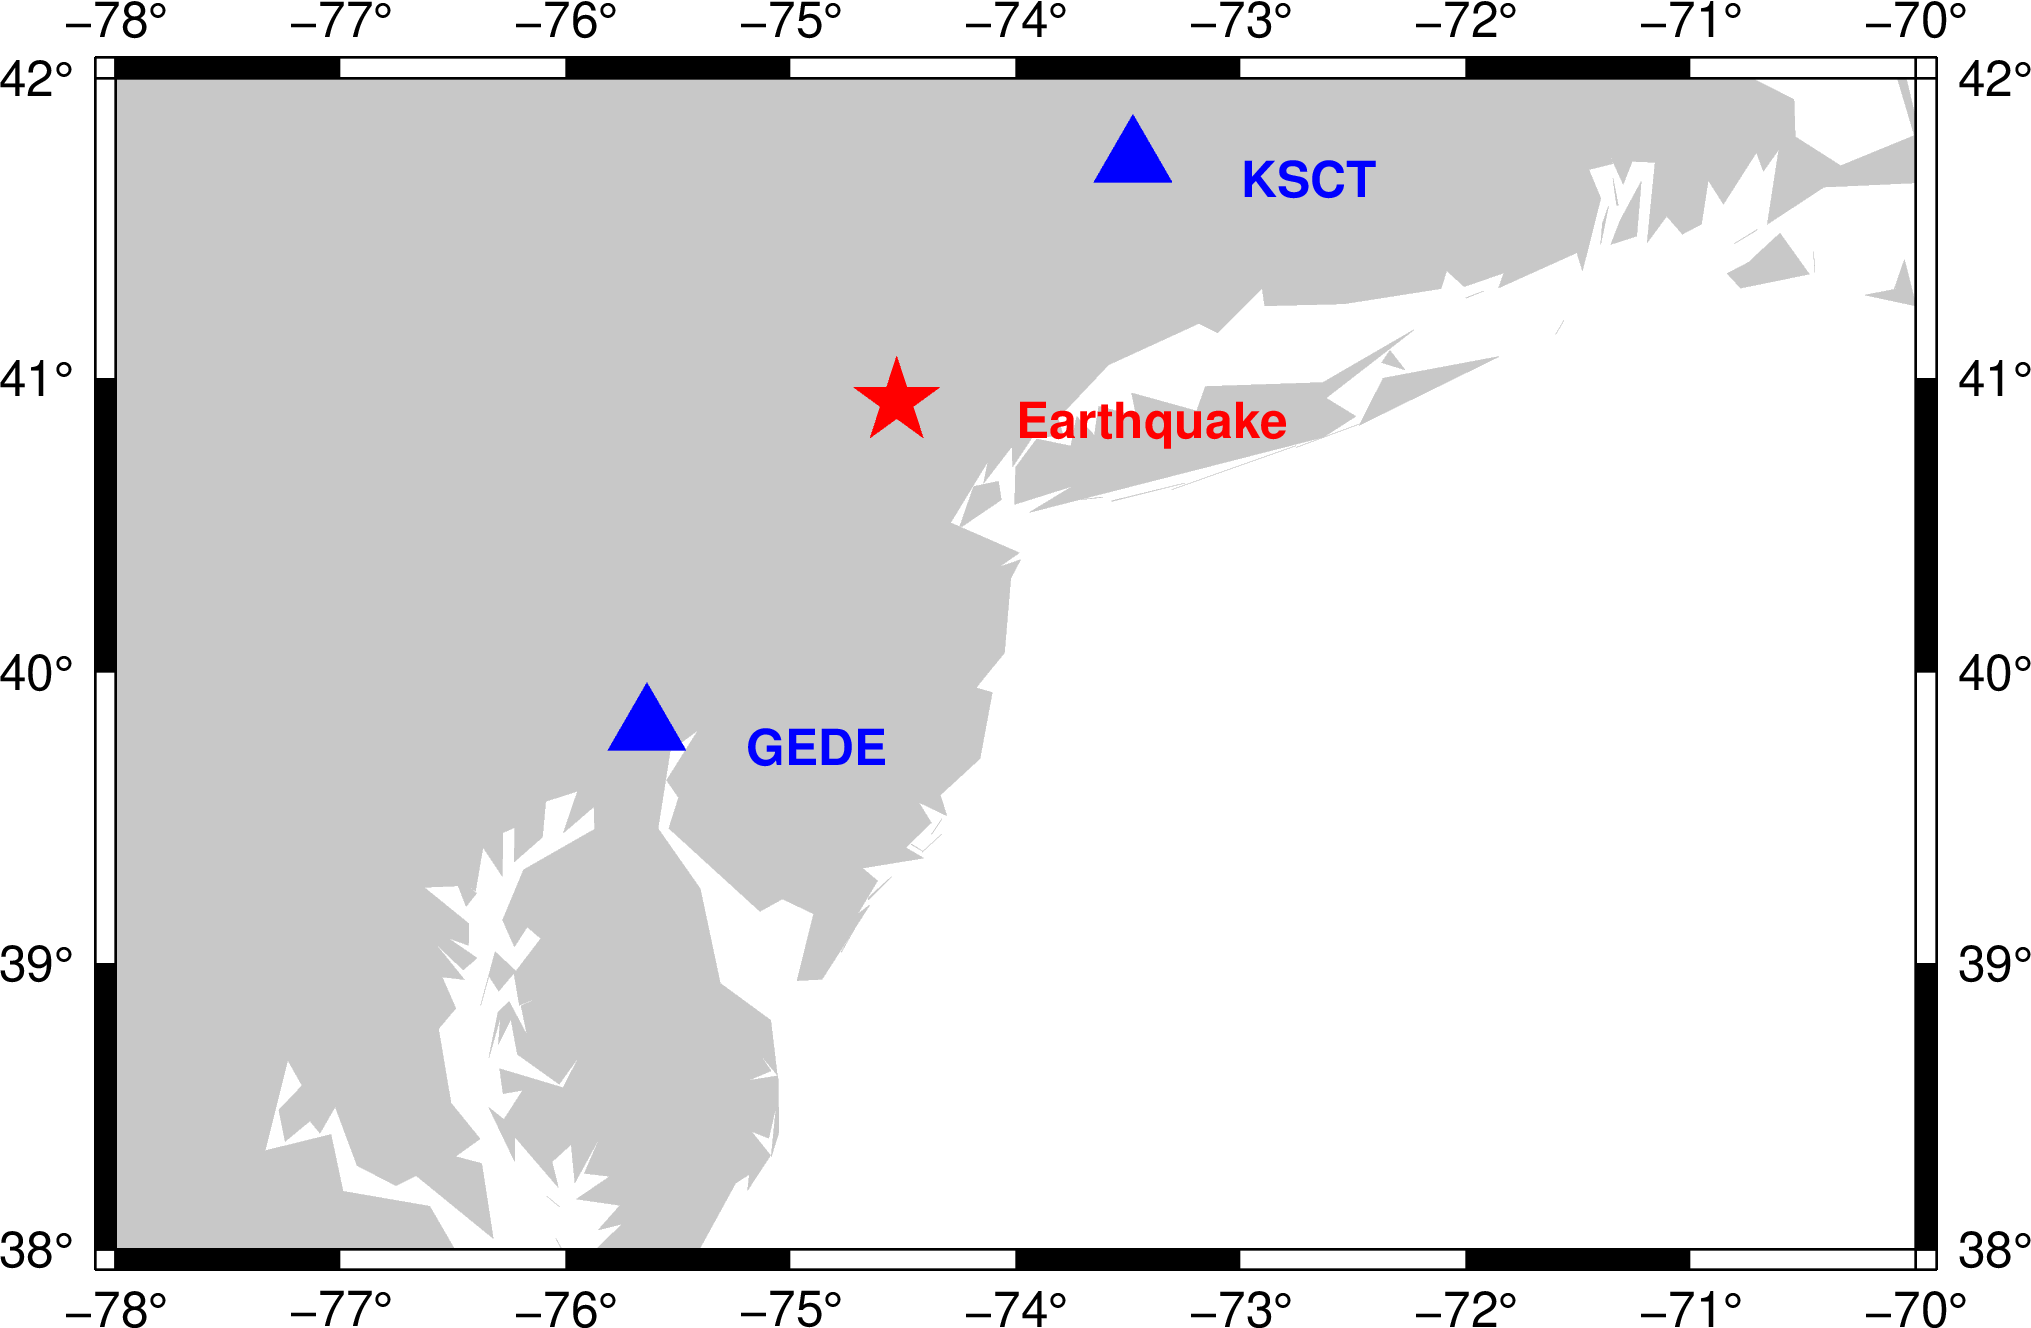

In [1]:
import os
from IPython.display import Image, display

# Get current directory
current_dir = os.getcwd()

# Construct full path to the image file
file_name = "map.png"  # replace with your actual file name
full_path = os.path.join(current_dir, file_name)

# Display the image
display(Image(filename=full_path))

##import

In [2]:
import datetime
import os
from glob import glob

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # to edit text in Illustrator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
import tqdm
import warnings

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD

%load_ext autoreload
%autoreload 2
import seismosocialdistancing

Step 2: Define Start/End dates and Seismic Channel

You'll have to make sure the seed_id you request is indeed available from the data_provider


In [3]:
# Make sure you take at least a full week (>=7 days) before the first "ban"
start = UTCDateTime("2022-08-29")
# Leaving UTCDateTime() empty means "now":
end = UTCDateTime("2022-09-01")

network_1 = "LD"
station_1 = "GEDE"
location_1 = ""
channel_1 = "BHZ"
dataset = "example"
time_zone = "America/New_York"
sitedesc = "in Uccle (Brussels, BE)"


network_2 = "LD"
station_2 = "KSCT"
location_2 = ""
channel_2 = "BHZ"
dataset = "example"
time_zone = "America/New_York"
sitedesc = "in Uccle (Brussels, BE)"

data_provider = "IRIS"

data_provider = "IRIS"
logo = None # 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/Logo_SED_2014.png/220px-Logo_SED_2014.png'
bans = {"2022-08-30 00:00":'Restaurants/Bars/Schools closed', 
        "2022-08-30 12:00":'Non-essential shops closed'}

datelist_1 = pd.date_range(start.datetime, min(end, UTCDateTime()).datetime, freq="D")
datelist_2 = pd.date_range(start.datetime, min(end, UTCDateTime()).datetime, freq="D")

download station 1

In [4]:
c = Client(data_provider)

nslc = "{}.{}.{}.{}".format(network_1, station_1, location_1, channel_1)
# make sure that wildcard characters are not in nslc
nslc = nslc.replace("*", "").replace("?", "")
pbar = tqdm.tqdm(datelist_1)
for day in pbar:
    datestr = day.strftime("%Y-%m-%d")
    fn = "{}_{}_{}.mseed".format(dataset, datestr, nslc)
    if day != UTCDateTime().datetime and os.path.isfile(fn):
        continue
    else:
        pbar.set_description("Fetching %s" % fn)
        try: 
            st = c.get_waveforms(network_1, station_1, location_1, channel_1,
                                  UTCDateTime(day)-1801, UTCDateTime(day)+86400+1801,
                                  attach_response=True)
            # the following two lines here prevent a crash when there is no data on a day
            if len(st) > 0:
                st.write(fn)
        except FDSNNoDataException:
            pbar.set_description("No data on FDSN server for %s" % fn)
            continue
        
resp = c.get_stations(UTCDateTime(day), network=network_1, station=station_1, location=location_1,
                      channel=channel_1, level="response")
print(resp)

Fetching example_2022-09-01_LD.GEDE..BHZ.mseed: 100%|█| 4/4 [00:05<00:00,  1.34s/i

Inventory created at 2024-09-23T10:35:44.094200Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2022-09-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			LD
		Stations (1):
			LD.GEDE (Greenville, DE, USA)
		Channels (1):
			LD.GEDE..BHZ


download station2

In [5]:
c = Client(data_provider)

nslc = "{}.{}.{}.{}".format(network_2, station_2, location_2, channel_2)
# make sure that wildcard characters are not in nslc
nslc = nslc.replace("*", "").replace("?", "")
pbar = tqdm.tqdm(datelist_2)
for day in pbar:
    datestr = day.strftime("%Y-%m-%d")
    fn = "{}_{}_{}.mseed".format(dataset, datestr, nslc)
    if day != UTCDateTime().datetime and os.path.isfile(fn):
        continue
    else:
        pbar.set_description("Fetching %s" % fn)
        try: 
            st = c.get_waveforms(network_2, station_2, location_2, channel_2,
                                  UTCDateTime(day)-1801, UTCDateTime(day)+86400+1801,
                                  attach_response=True)
            # the following two lines here prevent a crash when there is no data on a day
            if len(st) > 0:
                st.write(fn)
        except FDSNNoDataException:
            pbar.set_description("No data on FDSN server for %s" % fn)
            continue
        
resp = c.get_stations(UTCDateTime(day), network=network_2, station=station_2, location=location_2,
                      channel=channel_2, level="response")
print(resp)

Fetching example_2022-09-01_LD.KSCT..BHZ.mseed: 100%|█| 4/4 [00:06<00:00,  1.54s/i

Inventory created at 2024-09-23T10:36:14.049900Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2022-09-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			LD
		Stations (1):
			LD.KSCT (Kent School, Kent, CT)
		Channels (1):
			LD.KSCT..BHZ


In [6]:
import os
from obspy import read
import numpy as np
from datetime import datetime, timedelta

# Get the current working directory
current_directory = os.getcwd()
print(current_directory)

/home/jovyan/ProjectFinal


<b>Calculation of cross correlation<b>

Processing files: example_2022-08-29_LD.GEDE..BHZ.mseed, example_2022-08-29_LD.KSCT..BHZ.mseed


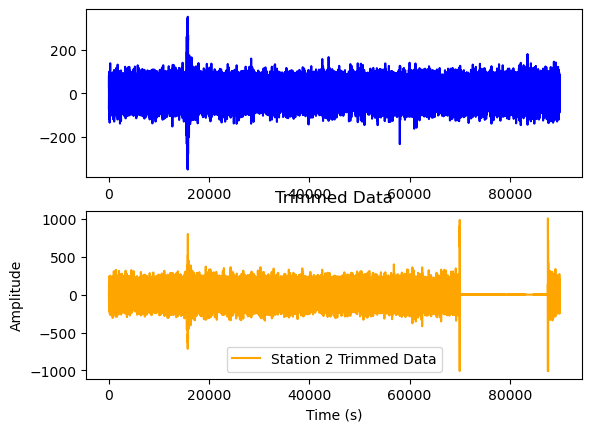

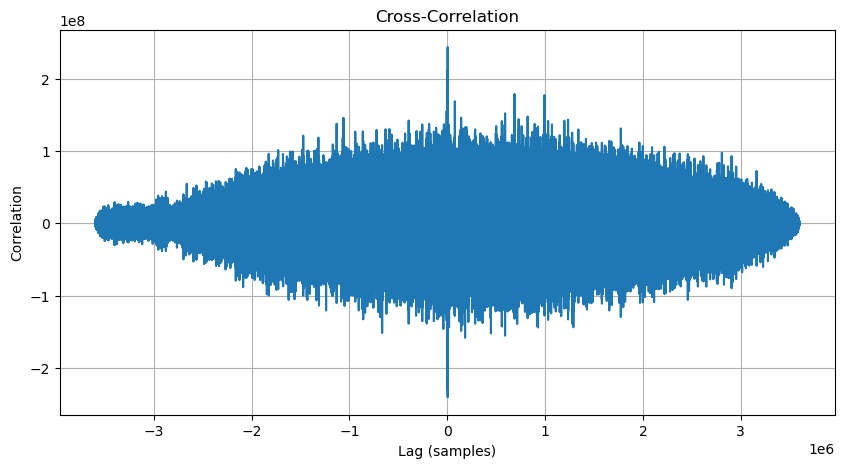

Processing files: example_2022-08-30_LD.GEDE..BHZ.mseed, example_2022-08-30_LD.KSCT..BHZ.mseed


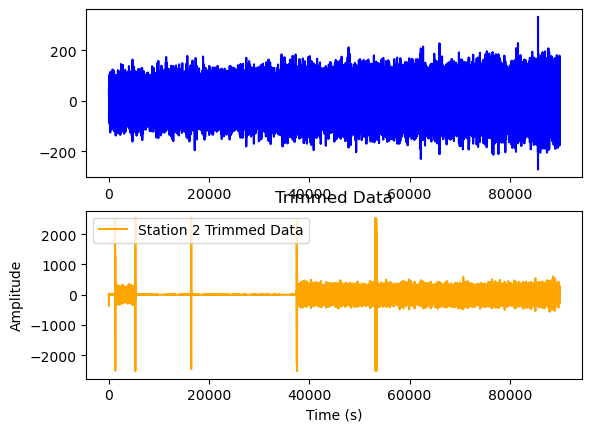

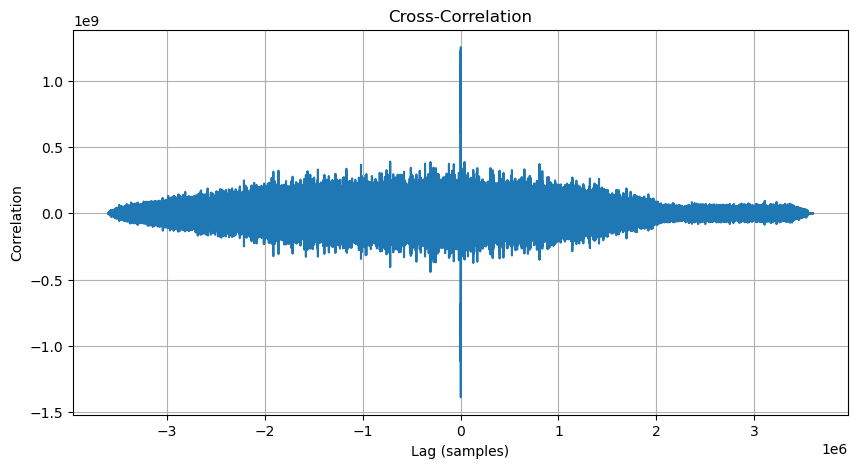

Processing files: example_2022-08-31_LD.GEDE..BHZ.mseed, example_2022-08-31_LD.KSCT..BHZ.mseed


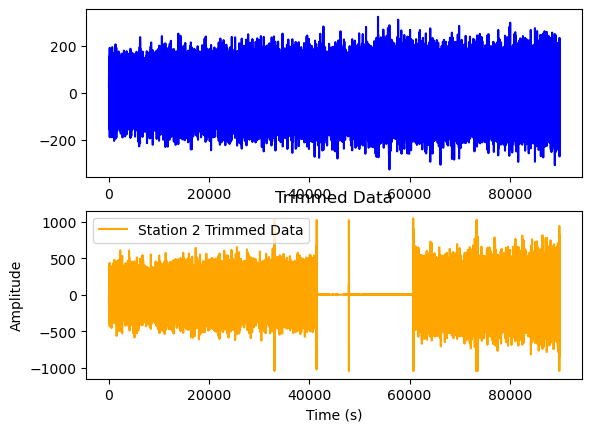

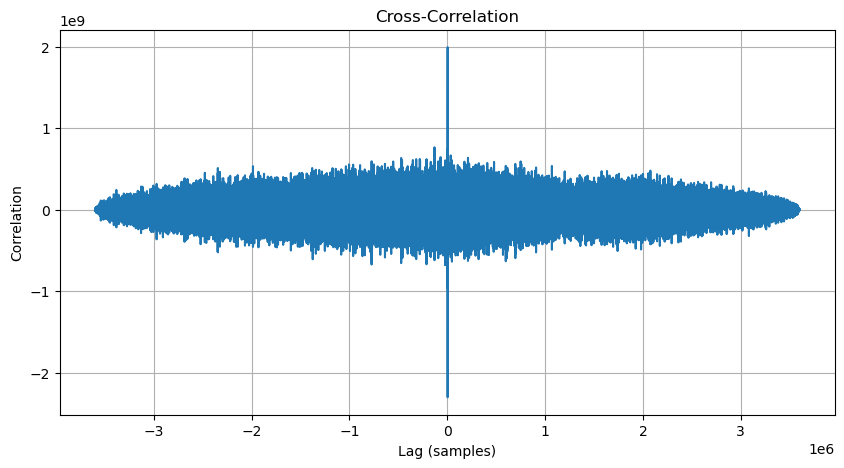

Processing files: example_2022-09-01_LD.GEDE..BHZ.mseed, example_2022-09-01_LD.KSCT..BHZ.mseed


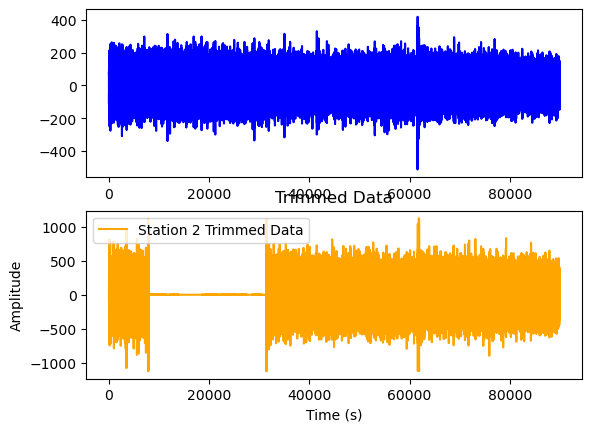

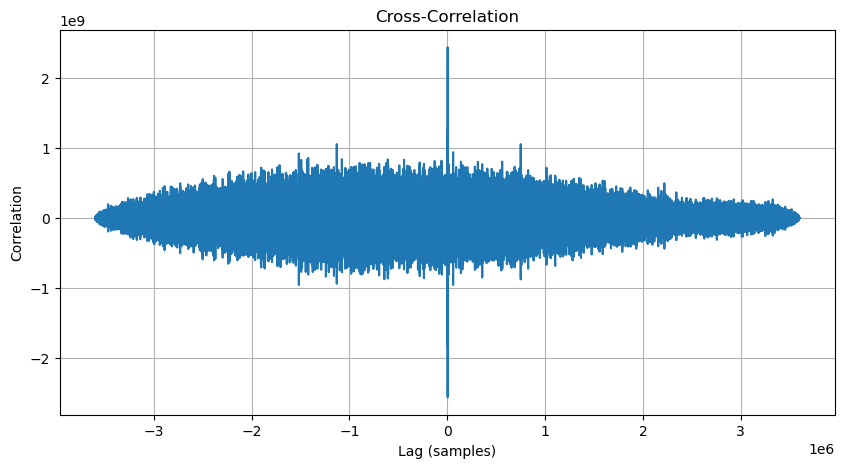

In [14]:
import os
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from obspy import read
from scipy.signal import correlate

# Define parameters for station 1
network_1 = "LD"
station_1 = "GEDE"
channel_1 = "BHZ"

# Define parameters for station 2
network_2 = "LD"
station_2 = "KSCT"
channel_2 = "BHZ"
start_date = datetime(2022, 8, 29)  # Start date
end_date = datetime(2022, 9, 1)    # End date

# Function to process cross-correlation for multiple days
def process_multiple_days(start_date, end_date):
    current_date = start_date
    
    while current_date <= end_date:
        date_str = current_date.strftime("%Y-%m-%d")
        
        # Construct file names for the current date
        station1_file = f"example_{date_str}_{network_1}.{station_1}..{channel_1}.mseed"
        station2_file = f"example_{date_str}_{network_2}.{station_2}..{channel_2}.mseed"
        
        print(f"Processing files: {station1_file}, {station2_file}")  # Print the constructed file names
        
        # Check if both files exist before processing
        if os.path.exists(station1_file) and os.path.exists(station2_file):
            process_and_cross_correlate(station1_file, station2_file, date_str)  # Pass date_str as an argument
        else:
            print(f"Files for {date_str} not found: {station1_file}, {station2_file}")
        
        # Move to the next day
        current_date += timedelta(days=1)

# Updated process_and_cross_correlate function
def process_and_cross_correlate(station1_file, station2_file, date_str):  # Accept date_str as a parameter
    # Load data
    st1 = read(station1_file)
    st2 = read(station2_file)

    # Ensure both streams have at least one trace
    if len(st1) == 0 or len(st2) == 0:
        print(f"One of the streams is empty for {station1_file} or {station2_file}.")
        return

    # Preprocess: Detrend data
    st1.detrend("linear")
    st2.detrend("linear")

    # Apply a band-pass filter to both streams
    st1.filter("bandpass", freqmin=0.1, freqmax=0.6, corners=2, zerophase=True)
    st2.filter("bandpass", freqmin=0.1, freqmax=0.6, corners=2, zerophase=True)

    # Trim data to the same length
    min_length = min(len(st1[0].data), len(st2[0].data))
    st1_data_trimmed = st1[0].data[:min_length]
    st2_data_trimmed = st2[0].data[:min_length]

    # Save background noise (you can choose a specific time window if needed)
    background_noise_1 = st1_data_trimmed.copy()
    background_noise_2 = st2_data_trimmed.copy()

    # Optionally remove large amplitude signals to isolate background noise
    threshold1 = 10  # Adjust this value to control the outlier threshold
    threshold2 = 0.2
    background_noise_1[np.abs(background_noise_1) > threshold1 * np.std(background_noise_1)] = 0
    background_noise_2[np.abs(background_noise_2) > threshold2 * np.std(background_noise_2)] = 0

    # Create a time axis based on sampling rate
    time_axis = np.arange(min_length) / st1[0].stats.sampling_rate

    # Plot trimmed data (optional)
    plt.subplot(2, 1, 1)
    plt.plot(time_axis, background_noise_1, label='Station 1 Trimmed Data', color='blue')
    plt.subplot(2, 1, 2)
    plt.plot(time_axis, background_noise_2, label='Station 2 Trimmed Data', color='orange')
    plt.title('Trimmed Data')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    
    plt.show()

    # Calculate cross-correlation of the background noise
    correlation = correlate(background_noise_1, background_noise_2, mode='full')

    # Create time axis for plotting cross-correlation (optional)
    lags = np.arange(-min_length + 1, min_length)

    # Plotting the cross-correlation (optional)
    plt.figure(figsize=(10, 5))
    plt.plot(lags, correlation)
    plt.title('Cross-Correlation')
    plt.xlabel('Lag (samples)')
    plt.ylabel('Correlation')
    
   # Save plot if needed (optional)
    plt.grid()
    plt.show()

   # Create a new filename based on the provided format and save results in 'corr' directory
    new_filename = f"correlation_{network_1}_{station_1}_{network_2}_{station_2}_{date_str}.txt"  
    #new_filepath = os.path.join(os.getcwd(), 'corr', new_filename)  # Save in 'corr' directory
    new_filepath = os.path.join(os.getcwd(), new_filename)

   # Save results (you can save correlation results in various formats)
    np.savetxt(new_filepath.replace('.mseed', '.txt'), correlation)  # Saving as .txt for easier reading

# Run the processing function for the specified date range
process_multiple_days(start_date, end_date)

<b> Calculate the Fourier transform <b>

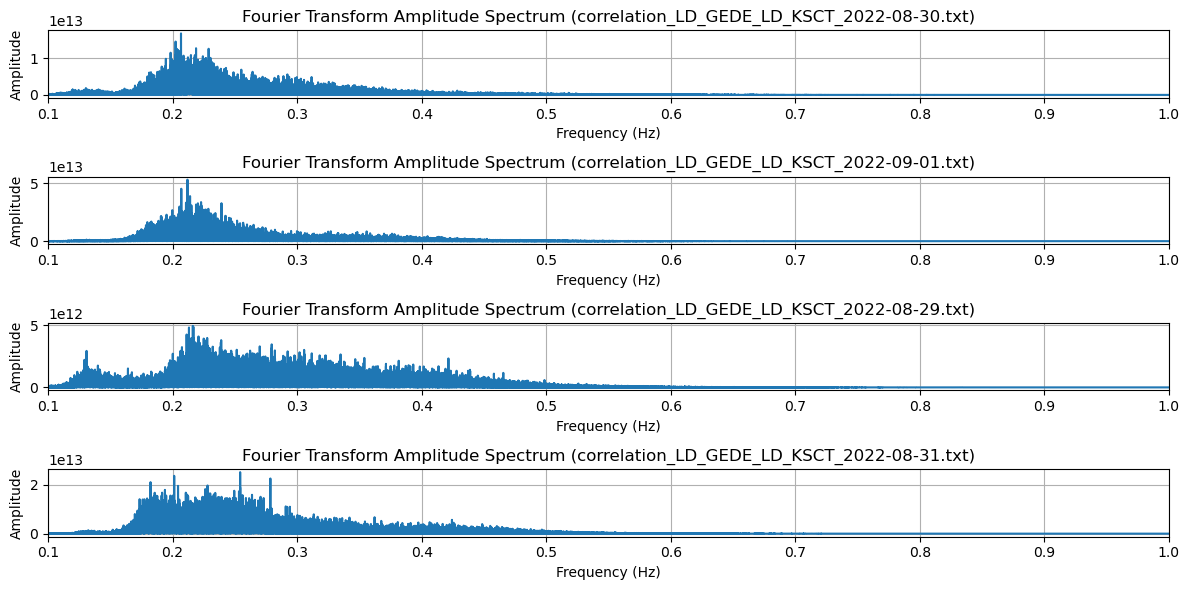

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import glob

# Define the path to your data files
file_pattern = 'correlation_*.txt'  # Adjust this pattern if needed
files = glob.glob(file_pattern)  # Get a list of all matching files

# Define band-pass filter parameters
low_cutoff = 0.1  # Lower cutoff frequency in Hz
high_cutoff = 1    # Upper cutoff frequency in Hz
sampling_rate = 40 # Adjust this to your actual sampling rate if known

# Create a figure for plotting
plt.figure(figsize=(12, 6))

# Loop through each file and process the data
for i, file in enumerate(files):
    # Load your cross-correlation data from the current file
    data = np.loadtxt(file)

    # Calculate the Fourier Transform
    fft_result = np.fft.fft(data)

    # Calculate the frequency bins
    N = len(data)  # Number of samples
    frequencies = np.fft.fftfreq(N, d=1/sampling_rate)

    # Create a band-pass filter mask
    filter_mask = (frequencies >= low_cutoff) & (frequencies <= high_cutoff)

    # Plot the amplitude spectrum (magnitude of FFT) for filtered frequencies
    plt.subplot(len(files), 1, i + 1)  # Create a subplot for each file
    plt.plot(frequencies[filter_mask], np.abs(fft_result[filter_mask]), label=f'FFT: {file}')
    plt.title(f'Fourier Transform Amplitude Spectrum ({file})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(low_cutoff, high_cutoff)  # Show only frequencies within the band-pass filter range
    plt.grid()

plt.tight_layout()
plt.show()

<b>Calculation of power spectrum density <b>

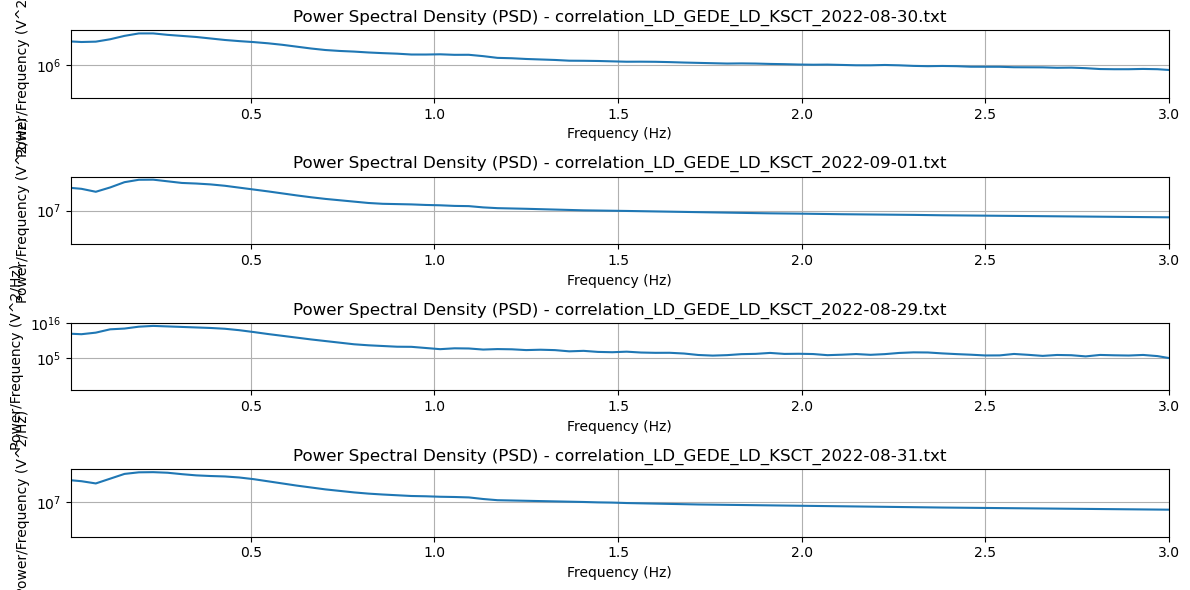

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import glob

# Define the path to your data files
file_pattern = 'correlation_*.txt'  # Adjust this pattern if needed
files = glob.glob(file_pattern)  # Get a list of all matching files

# Define band-pass filter parameters
low_cutoff = 0.01  # Lower cutoff frequency in Hz
high_cutoff = 3     # Upper cutoff frequency in Hz
sampling_rate = 40  # Adjust this to your actual sampling rate if known

# Create a figure for plotting
plt.figure(figsize=(12, 6))

# Loop through each file and process the data
for i, file in enumerate(files):
    # Load your cross-correlation data from the current file
    data = np.loadtxt(file)

    # Calculate the Fourier Transform
    fft_result = np.fft.fft(data)

    # Calculate the frequency bins
    N = len(data)  # Number of samples
    frequencies = np.fft.fftfreq(N, d=1/sampling_rate)

    # Create a band-pass filter mask
    filter_mask = (frequencies >= low_cutoff) & (frequencies <= high_cutoff)

    # Apply the filter in the frequency domain
    filtered_fft_result = np.zeros_like(fft_result)
    filtered_fft_result[filter_mask] = fft_result[filter_mask]

    # Inverse Fourier Transform to get back to time domain
    filtered_data = np.fft.ifft(filtered_fft_result)

    # Calculate Power Spectral Density (PSD) using Welch's method
    frequencies_psd, psd = welch(filtered_data.real, fs=sampling_rate, nperseg=1024)

    # Plotting the Power Spectral Density (PSD) for each file in a subplot
    plt.subplot(len(files), 1, i + 1)  # Create a subplot for each file
    plt.semilogy(frequencies_psd, psd)
    plt.title(f'Power Spectral Density (PSD) - {file}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (V^2/Hz)')
    plt.xlim(low_cutoff, high_cutoff)  # Show only frequencies within the band-pass filter range
    plt.grid()

plt.tight_layout()
plt.show()